In [1]:
from functools import wraps
from typing import List, Tuple
import mosek
import numpy as np
import scipy.sparse as sp
from numpy import linalg as LA
import cvxpy as cp
import argparse

from cvxpy.atoms import bmat, reshape, trace, upper_tri
from cvxpy.constraints.psd import PSD
from cvxpy.expressions.variable import Variable
from cvxpy.atoms.atom import Atom
from cvxpy.atoms.quad_form import QuadForm
from cvxpy.constraints.constraint import Constraint

In [2]:
import sys
sys.argv = ['']

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--d1", type=int, help="row dimension of the action matrix", default=3)
parser.add_argument("--d2", type=int, help="column dimension of the action matrix", default=3)
parser.add_argument("--r", type=int, help="rank of the hidden matrix", default=1)
parser.add_argument("--same", type=bool, help='Whether we should use equal strategy which is ours', default=False)
parser.add_argument("--inc",type=int, help='Incremental scale of the experiment', default=10000)
parser.add_argument("--T_min",type=int, help='Minimum length of experiment to examine', default=0)
parser.add_argument("--howlong",type=int, help='Maximum multiple of T_min for the experiment. For example, howlong=20 and inc=2000 means maximum 40000 rounds', default=10)
parser.add_argument("--repeat",type=int, help='How many times it will repeat for each experiment setting', default=30)
parser.add_argument("--sigma",type=float, help='Variance', default=0.1)
parser.add_argument("--delta",type=float, help='Error probability in bandit', default=0.05)
parser.add_argument("--action_set", help='which action will I use - \'hard\' is Case 1 in the figure, and \'uniform\' is the Case 2 in the figure', default='hard')
parser.add_argument("--num_of_action_set", type=int, help='Number of actions in the action set in Case 2. Case 1 has fixed number of actions', default=150),
parser.add_argument("--cheat", type=float, help='theta_0 = cheat * theta', default=0)
args = parser.parse_args()


# functions for the optimization of lasso. Basically cvxpy format functions.
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y) ** 2

def regularizer(beta,d1,d2):
    return cp.norm(cp.reshape(beta, (d1,d2)), 'nuc')

def objective_fn(X, Y, beta, lambd, d1, d2):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta,d1,d2)

In [4]:
#basic settings
d1=args.d1
d2=args.d2
d=args.d1*args.d2
r=args.r
delta=args.delta

N_a = d
A= np.zeros((N_a,d))

opt = 1 / np.sqrt(d)
A[0][0]=opt
for i in range(1,d):
    A[i][0]=1
    A[i][i]=opt
'''
N_a=args.num_of_action_set
A=np.zeros((N_a,d))
for i in range(0,N_a):
    A[i]=np.random.normal(0,1,d)
    A[i]=A[i]/LA.norm(A[i])
'''
B=np.zeros((N_a,d))
for i in range(0,N_a):
    B[i]=(np.reshape(A[i], (d1,d2)).T).flatten()

########################## Exploration plan optimization stage - min eigenvalue ################################

mu_eig=cp.Variable(N_a, pos=True)
X_eig=A.T@ cp.diag(mu_eig) @A

constraints_eig = [cp.sum(mu_eig)==1]
prob_eig = cp.Problem(cp.Maximize(cp.lambda_min(X_eig)), constraints_eig)
prob_eig.solve(solver=cp.MOSEK, verbose=True)

print('Set2 Optimization Finished\n')
print('Mu_eig')
print(mu_eig.value)
dist_eig=mu_eig.value/np.sum(mu_eig.value)
print('Cmin')
Cmin=prob_eig.value
print(1/prob_eig.value)

Q_eig=A.T@ np.diag(dist_eig) @A
Q_inv_eig=LA.inv(Q_eig)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 17 12:59:40 AM: Your problem has 9 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 17 12:59:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 17 12:59:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 17 12:59:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 17 12:59:40 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 17 12:59:40 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

In [5]:
mu=cp.Variable(N_a, pos=True)
X=A.T@ cp.diag(mu) @A
X2= B.T@ cp.diag(mu) @B

T = Variable((d, d), symmetric=True)
M = bmat([[X, np.eye(d)],
          [np.eye(d), T]])
Tsum=np.zeros([d2,d2])
T2 = Variable((d, d), symmetric=True)
M2 = bmat([[X2, np.eye(d)],
          [np.eye(d), T2]])
constraints = [M>>0, M2 >> 0, cp.sum(mu)==1]
Tsum=np.zeros([d2,d2])
Tsum2=np.zeros([d1,d1])
for i in range(0,d1):
    Tsum=Tsum+T[d2*i:d2*(i+1), :][:,d2*i:d2*(i+1)]
for j in range(0,d2):
    Tsum2=Tsum2+T2[d1*i:d1*(i+1), :][:,d1*i:d1*(i+1)]
objective = cp.Minimize(cp.maximum(cp.lambda_max(Tsum), cp.lambda_max(Tsum2)))

prob=cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK,verbose=True)

dist_our=mu.value/np.sum(mu.value)
Bmin=prob.value
print(prob.value)


Q=A.T@ np.diag(dist_our) @A
Q_inv=LA.inv(Q)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 17 12:59:43 AM: Your problem has 171 variables, 3 constraints, and 0 parameters.
(CVXPY) Oct 17 12:59:43 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 17 12:59:43 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 17 12:59:43 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 17 12:59:43 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 17 12:59:43 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [11]:
T0=args.T_min                                   # Initial number of samples for regression
repeative=args.repeat                           # How many times we repeat the same setting
howlong=args.howlong                            # How many cases of 'number of samples' we want to observe.
                                                # For example, if T_min=1000 and howlong=3,
                                                # we check the cases of T=1000,2000,3000
wholelength=repeative*howlong                   # The maximum number of the experiments
sigma=args.sigma                                # Variance of the noise


hist_true=np.zeros((wholelength,d))             #history of true theta, true hidden parameters

hist_esti=np.zeros((wholelength,d))             #history of the estimated theta by our method
hist_esti_raw=np.zeros((wholelength,d))         #history of the estimated theta by our method before thresholding
errors=np.zeros(howlong)                        #l1 error between true and our estimation
all_error=np.zeros(wholelength)                 #history of the error of all experiments. Used it for measuring variance
vari_our=np.zeros(howlong)                      #history of the variance of the l1 norm difference
time_our=np.zeros(wholelength)

hist_esti_eig_nuc=np.zeros((wholelength,d))         #history of the estimated theta by nuc's method
errors_eig_nuc=np.zeros(howlong)                    #l1 error between true and nuc's estimation
all_error_eig_nuc=np.zeros(wholelength)             #history of the error of all experiments with nuc's setting. Used it for measuring variance
vari_eig_nuc=np.zeros(howlong)                      #history of the variance of the l1 norm difference in nuc's setting
time_eig_nuc=np.zeros(wholelength)


hist_esti_our_nuc=np.zeros((wholelength,d))         #history of the estimated theta by nuc's method
errors_our_nuc=np.zeros(howlong)                    #l1 error between true and nuc's estimation
all_error_our_nuc=np.zeros(wholelength)             #history of the error of all experiments with nuc's setting. Used it for measuring variance
vari_our_nuc=np.zeros(howlong)                      #history of the variance of the l1 norm difference in nuc's setting
time_our_nuc=np.zeros(wholelength)


hist_esti_eig_thr=np.zeros((wholelength,d))         #history of the estimated theta by nuc's method
errors_eig_thr=np.zeros(howlong)                    #l1 error between true and nuc's estimation
all_error_eig_thr=np.zeros(wholelength)             #history of the error of all experiments with nuc's setting. Used it for measuring variance
vari_eig_thr=np.zeros(howlong)                      #history of the variance of the l1 norm difference in nuc's setting
time_eig_thr=np.zeros(wholelength)




for i in range(0,howlong):
    T0=T0+args.inc
    print('=====Repetition for total time %d=====' % (T0))
    for rep in range(0,repeative):
        #setting theta - changes over each experiment
        theta_v1 = np.random.normal(0,1,d1)
        theta_v1=theta_v1/LA.norm(theta_v1)
        theta_v2 = np.random.normal(0,1,d2)
        theta_v2=theta_v2/LA.norm(theta_v2)
        theta = np.matrix.flatten(np.outer(theta_v1, theta_v2))
        theta_0 = args.cheat*theta
        a_true=A[np.argmax(A@theta)]
        S=np.max(np.abs(A@theta))

        
        #Experiment 1: PopArt experiment
        S_0=np.max(np.abs(A@(theta-theta_0)))
        nu_our = np.sqrt(2*np.log(2*np.max((d1,d2))/delta)/Bmin/T0)/(S_0+sigma)
        nu_eig = np.sqrt(2*Cmin*np.log(2*np.max((d1,d2))/delta)/np.max((d1,d2))/T0)/(S_0+sigma)
        
        threshold_our = np.sqrt(2*Bmin*np.log((d1+d2)/delta)/T0)
        threshold_eig = np.sqrt(2*(d1+d2)*np.log((d1+d2)/delta)/Cmin/T0)
        hist_true[i*repeative+rep]=theta
        X_hist=np.zeros((T0,d))
        X_hist_eig=np.zeros((T0,d))
        
        hist_our_nuc=np.zeros((T0, d))                        #temporary history for the action of nuc's method, since it computes LASSO optimization
        r_our_nuc=np.zeros(T0)                                #temporary history for the reward

        for t in range(0,T0):
            act_t=A[np.random.choice(N_a, p=dist_our)]
            hist_our_nuc[t]=act_t
            r=theta@act_t+np.random.normal(0,sigma)
            r_our_nuc[t]=r
            X_hist[t]=(r-act_t@theta_0)*(Q_inv@act_t)+theta_0
        theta_1=matrix_catoni(X_hist,T0,d1,d2,nu_our)
        theta_hat=np.matrix.flatten(thresholding(theta_1, threshold_our))
        hist_esti[i*repeative+rep]=theta_hat
        all_error[i*repeative+rep]=LA.norm((theta-theta_hat).reshape((d1,d2)),'nuc')
        errors[i]+=LA.norm((theta-theta_hat).reshape((d1,d2)),'nuc')/repeative

        beta_our_nuc = cp.Variable(d)
        lambd_our_nuc = (sigma+S)*np.sqrt(np.log(d1+d2) * T0)
        lassosol_our_nuc = cp.Problem(cp.Minimize(objective_fn(hist_our_nuc, r_our_nuc, beta_our_nuc, lambd_our_nuc,d1, d2)))
        lassosol_our_nuc.solve()
        beta_our_nuc_hat = beta_our_nuc.value
        hist_esti_our_nuc[i*repeative+rep]=beta_our_nuc_hat
        errors_our_nuc[i]+=LA.norm((theta-beta_our_nuc_hat).reshape((d1,d2)),'nuc')/repeative
        all_error_our_nuc[i*repeative+rep]=LA.norm((theta-beta_our_nuc_hat).reshape((d1,d2)),'nuc')
        
        #a_hat=A[np.argmax(A@theta_hat)]

        #Experiment 2 - Nuclear norm regularized setting experiment
        hist_b=np.zeros((T0, d))                        #temporary history for the action of nuc's method, since it computes LASSO optimization
        r_b=np.zeros(T0)                                #temporary history for the reward
        for t in range(0,T0):
            act_h_t = A[np.random.choice(N_a, p=dist_eig)]
            hist_b[t]=act_h_t
            r_b[t] = theta @ act_h_t + np.random.normal(0, sigma)
            X_hist_eig[t]=(r_b[t]-act_h_t@theta_0)*(Q_inv_eig@act_h_t)+theta_0
        beta = cp.Variable(d)
        lambd_b = (sigma+S)*np.sqrt(np.log(d1+d2) * T0)
        lassosol = cp.Problem(cp.Minimize(objective_fn(hist_b, r_b, beta, lambd_b,d1, d2)))
        lassosol.solve()
        beta_hat = beta.value
        hist_esti_eig_nuc[i*repeative+rep]=beta_hat
        errors_eig_nuc[i]+=LA.norm((theta-beta_hat).reshape((d1,d2)),'nuc')/repeative
        all_error_eig_nuc[i*repeative+rep]=LA.norm((theta-beta_hat).reshape((d1,d2)),'nuc')
        #a_hat_h=A[np.argmax(A@beta_hat)]

        theta_eig_thr_raw=matrix_catoni(X_hist_eig,T0,d1,d2,nu_eig)
        theta_eig_thr_hat=np.matrix.flatten(thresholding(theta_eig_thr_raw, threshold_eig))
        hist_esti_eig_thr[i*repeative+rep]=theta_eig_thr_hat
        all_error_eig_thr[i*repeative+rep]=LA.norm((theta-theta_eig_thr_hat).reshape((d1,d2)),'nuc')
        errors_eig_thr[i]+=LA.norm((theta-theta_eig_thr_hat).reshape((d1,d2)),'nuc')/repeative


    vari_our[i]=np.std(all_error[repeative*i:repeative*(i+1)-1])
    vari_eig_nuc[i]=np.std(all_error_eig_nuc[repeative*i:repeative*(i+1)-1])
    vari_our_nuc[i]=np.std(all_error_our_nuc[repeative*i:repeative*(i+1)-1])
    vari_eig_thr[i]=np.std(all_error_eig_thr[repeative*i:repeative*(i+1)-1])


=====Repetition for total time 10000=====


/var/folders/rw/6k0q0dlj29qcgf6thm85nsvc0000gn/T/ipykernel_94549/1151793174.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  hist_esti[i*repeative+rep]=theta_hat
/var/folders/rw/6k0q0dlj29qcgf6thm85nsvc0000gn/T/ipykernel_94549/1151793174.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  hist_esti_eig_thr[i*repeative+rep]=theta_eig_thr_hat


=====Repetition for total time 20000=====
=====Repetition for total time 30000=====
=====Repetition for total time 40000=====
=====Repetition for total time 50000=====
=====Repetition for total time 60000=====
=====Repetition for total time 70000=====
=====Repetition for total time 80000=====
=====Repetition for total time 90000=====
=====Repetition for total time 100000=====


In [6]:
def catoni_indiv(v):
    return np.sign(v)*np.log(1+np.abs(v)+v*v/2)

In [7]:
def symmetrize(X,d1,d2):
    X_mat=X.reshape((d1,d2))
    return np.block([[np.zeros((d1,d1)), X_mat],[np.transpose(X_mat), np.zeros((d2,d2))]])

In [8]:
def matrix_catoni_one(X,d1,d2, nu):
    eigenvalue, eigenvectors = LA.eig(symmetrize(X,d1,d2))
    '''
    if any(np.iscomplex(eigenvalue)):
        print('Eigenvalues:')
        print(eigenvalue)
        print('Eigenvectors:')
        print(eigenvectors)
        print('X:')
        print(X)
    '''
    result=eigenvectors@ np.diag(catoni_indiv(nu*eigenvalue)) @eigenvectors.T
    return result

In [9]:
def matrix_catoni(X,T0,d1,d2, nu):
    D=d1+d2
    result=np.zeros((D,D))
    for i in range(0, T0):
        result= result + matrix_catoni_one(X[i],d1,d2,nu)/T0/nu
    final_result = result[0:d1, d1:D]
    return final_result
    
    

In [10]:
def thresholding(X, threshold):
    U, S, V=LA.svd(X)
    newS=np.diag(np.abs(S)>threshold)*(S)
    return (U@newS)@V

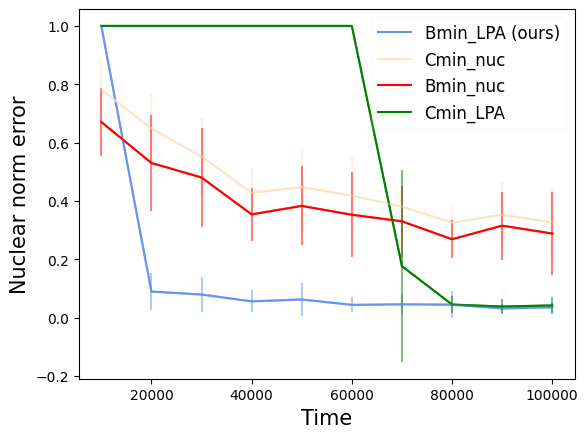

In [14]:
import matplotlib.pyplot as plt
timeline=np.linspace(args.inc,args.inc*args.howlong,args.howlong)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Nuclear norm error', fontsize=15)
plt.plot(timeline,errors, label='Bmin_LPA (ours)', color='cornflowerblue')
plt.errorbar(timeline, errors, vari_our, color='cornflowerblue', alpha=0.5)
plt.plot(timeline,errors_eig_nuc, color='bisque', label='Cmin_nuc')
plt.errorbar(timeline, errors_eig_nuc, vari_eig_nuc, color='bisque', alpha=0.5)
plt.plot(timeline,errors_our_nuc, color='red', label='Bmin_nuc')
plt.errorbar(timeline, errors_our_nuc, vari_our_nuc, color='red', alpha=0.5)
plt.plot(timeline,errors_eig_thr, color='green', label='Cmin_LPA')
plt.errorbar(timeline, errors_eig_thr, vari_eig_thr, color='green', alpha=0.5)

plt.legend(fontsize=12, framealpha=0.1)
plt.savefig('hard_experiment.png')
plt.show()

In [ ]:
errors_eig_thr

In [ ]:
LA.norm(hist_true[50].reshape((d1,d2)), 'nuc')

In [18]:
theta_eig_thr_hat

array([-0.02005408,  0.10444193,  0.24785658, -0.1890456 , -0.03120811,
       -0.04165719,  0.21695116,  0.51485812, -0.39269347, -0.06482679,
       -0.00549104,  0.0285974 ,  0.06786599, -0.05176286, -0.00854514,
       -0.03244398,  0.16896864,  0.40098829, -0.30584247, -0.05048922,
       -0.01655173,  0.0862016 ,  0.20456952, -0.15602961, -0.02575775])

In [17]:
theta

array([-6.17402294e-04,  9.51757006e-02,  2.07480401e-01, -1.86758111e-01,
       -2.40042844e-02, -1.36313573e-03,  2.10134299e-01,  4.58086972e-01,
       -4.12335129e-01, -5.29980177e-02, -3.45799492e-04,  5.33067487e-02,
        1.16207241e-01, -1.04600940e-01, -1.34445068e-02, -1.14087526e-03,
        1.75871718e-01,  3.83395492e-01, -3.45103527e-01, -4.43566448e-02,
       -8.32369097e-04,  1.28313926e-01,  2.79720816e-01, -2.51783451e-01,
       -3.23620834e-02])

In [25]:
Cmin

0.025379663704752115

In [29]:
Cmin/d

0.0010151865481900846

In [36]:
theta_eig_thr_raw

array([[ 0.05069593,  0.17542905, -0.04567316, -0.01512584, -0.04365961],
       [-0.27999022, -0.12869112,  0.22325245,  0.21434523,  0.11480653],
       [ 0.33360193,  0.17140612, -0.37069444, -0.14964351, -0.16087806],
       [-0.29685493, -0.27840933,  0.35387279,  0.15497944,  0.1609527 ],
       [ 0.2551975 ,  0.11157018, -0.28052154, -0.11236922, -0.14201917]])

In [37]:
theta_eig_thr_hat

array([ 0.07855586,  0.05059311, -0.08369642, -0.04172563, -0.03947957,
       -0.25036345, -0.16124407,  0.26674681,  0.13298272,  0.12582438,
        0.32395346,  0.20863898, -0.34515243, -0.1720707 , -0.16280828,
       -0.32950244, -0.21221274,  0.35106452,  0.17501809,  0.16559701,
        0.24540604,  0.1580513 , -0.261465  , -0.13034955, -0.12333295])

In [38]:
theta

array([ 0.08538707,  0.05446218, -0.08016523, -0.05098358, -0.04702032,
       -0.25446961, -0.16230758,  0.23890753,  0.15194069,  0.14012945,
        0.32868343,  0.20964316, -0.30858281, -0.19625286, -0.18099697,
       -0.31240416, -0.1992598 ,  0.2932991 ,  0.18653271,  0.17203243,
        0.24806708,  0.15822388, -0.23289655, -0.14811782, -0.13660376])

In [53]:
X_hist

array([[-9.39545434e-15,  0.00000000e+00,  0.00000000e+00, ...,
        -3.75818174e-14, -7.51636347e-14, -5.63727261e-14],
       [ 1.90614397e-01, -9.53071987e-01, -9.53071987e-01, ...,
        -9.53071987e-01, -9.53071987e-01, -9.53071987e-01],
       [-6.97438177e-15,  2.86330441e-14,  3.69515305e-14, ...,
         1.59796353e-15,  3.67758511e-15,  5.75720670e-15],
       ...,
       [ 4.59953342e-01, -2.29976671e+00, -2.29976671e+00, ...,
        -2.29976671e+00, -2.29976671e+00, -2.29976671e+00],
       [-4.56546847e-15,  1.94547032e-14, -7.52641031e-15, ...,
         2.22217282e+02, -4.79980805e-14, -3.11348846e-14],
       [ 1.60927654e+00, -8.04638269e+00, -8.04638269e+00, ...,
        -8.04638269e+00, -8.04638269e+00, -8.04638269e+00]])

In [82]:
errors_eig_nuc

array([1.0275879 , 1.03116073, 1.04418135, 1.06226052, 1.05240284,
       1.02875842, 1.05479029, 1.06241946, 1.04059061, 1.04534118])

In [15]:
XX=np.array([-0.75984947,  3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,
  3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,
  3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,
  3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,
  3.79924734])

In [16]:
symmetrize(XX,d1,d2)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.75984947,  3.79924734,  3.79924734,  3.79924734,  3.79924734],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734],
       [-0.75984947,  3.79924734,  3.79924734,  3.79924734,  3.79924734,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.79924734,  3.79924734,  3.79924734,  3.79924734,  3.79924734,
         0.        ,  0.        ,  0.        

In [17]:
egv,egvec=LA.eig(symmetrize(XX,d1,d2))

In [18]:
any(np.iscomplex(egv))

False

In [15]:
threshold_our

1.7896264826204007

In [16]:
threshold_eig

4.786986447091348

In [3]:
np.max([1,2])

2

NameError: name 'A' is not defined